#### Татур А.А.
#### v.0.1
#### Цель: Построить ассоциативные правила.

#### Импорт

In [105]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import re

from mlxtend.preprocessing import TransactionEncoder

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax
from mlxtend.frequent_patterns import association_rules

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

#### Загрузка данных

In [76]:
df = pd.read_csv('dataset.csv',
                 header=None, 
                skipinitialspace = True) #удалим все пробелы в начале
df = df.fillna('999') #меняем np.nan на 999, чтобы потом выкинуть из датасета
goods = pd.Series(df.values.tolist())

In [77]:
#### Убираем все пробелы
for x in range(len(goods)):
    a=0
    for i in goods[x]:
        goods[x][a] = i.replace(' ', '')
        a+=1

#### Препроцессинг

In [78]:
encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(goods).transform(goods), 
                            columns=encoder.columns_)
transactions.drop('999', axis=1, inplace=True) #Убираем колонку с пустыми значениями, которые были заменены на 999

#### Алгоритм Apriori

In [79]:
frequent_itemsets_apriori=apriori(transactions, min_support= 6/len(goods), use_colnames=True, max_len = 3)

In [80]:
frequent_itemsets_apriori['length']=frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))
frequent_itemsets_apriori

,support,itemsets,length
0,0.263509,(all-purpose),1
1,0.264176,(aluminumfoil),1
2,0.278185,(bagels),1
3,0.262842,(beef),1
4,0.261508,(butter),1
...,...,...,...
9172,0.030020,"(waffles, toiletpaper, yogurt)",3
9173,0.036024,"(waffles, tortillas, vegetables)",3
9174,0.045364,"(yogurt, tortillas, vegetables)",3
9175,0.014676,"(waffles, yogurt, tortillas)",3


In [81]:
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift",  min_threshold = 1.5)
display(rules_apriori.sort_values (by='lift', ascending=False).head(5))
print("Rules identified: {}".format(len(rules_apriori)))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(juice),"(sandwichloaves, yogurt)",0.257505,0.064043,0.026017,0.101036,1.577639,0.009526,1.041151
16,"(sandwichloaves, yogurt)",(juice),0.064043,0.257505,0.026017,0.406250,1.577639,0.009526,1.250518
8,"(spaghettisauce, dishwashingliquid/detergent)",(fruits),0.061374,0.263509,0.025350,0.413043,1.567474,0.009178,1.254762
9,(fruits),"(spaghettisauce, dishwashingliquid/detergent)",0.263509,0.061374,0.025350,0.096203,1.567474,0.009178,1.038535
4,"(beef, mixes)",(pork),0.065377,0.250167,0.025350,0.387755,1.549986,0.008995,1.224728


Rules identified: 22


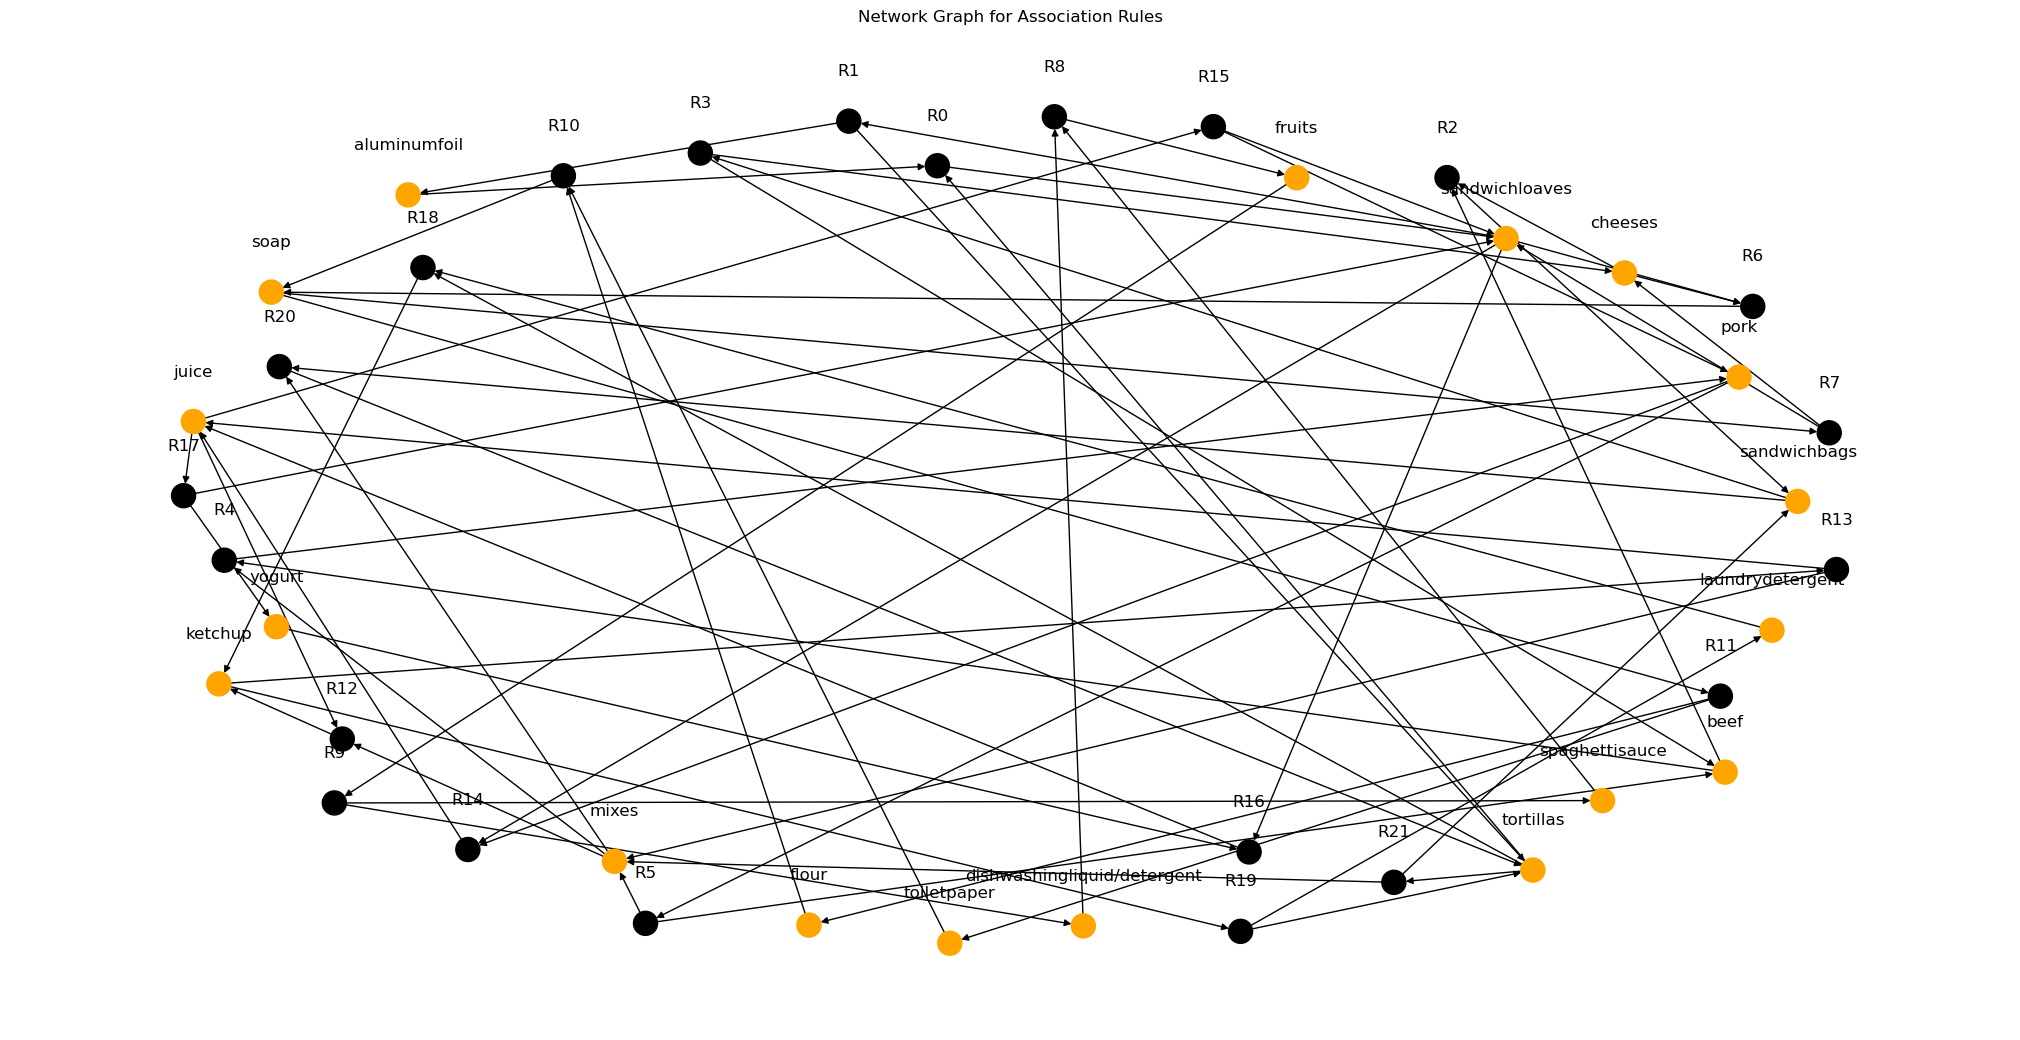

In [85]:
def draw_network(rules, rules_to_show):
  # Ориентированный граф от NetworkX
    network = nx.DiGraph()
    plt.figure (figsize=(20,10))

  
  # Перебор количества правил для отображения
    for i in range(rules_to_show):
    
    # Добавление узла правила
        network.add_nodes_from(["R"+str(i)])
        for antecedents in rules.iloc[i]['antecedents']: 
        # Добавление узла-предшественника и ссылки на правило
            network.add_nodes_from([antecedents])
            network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
        for consequents in rules.iloc[i]['consequents']:
        # Добавление узла-последователя и ссылки на правило
            network.add_nodes_from([consequents])
            network.add_edge("R"+str(i), consequents,  weight = 2)

    color_map=[]  
  
  # Для каждого узла, если это правило, цвет черный, в противном случае - оранжевый.
    for node in network:
        if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
        else:
            color_map.append('orange')
  
  # Расположение узлов с помощью spring layout
    pos = nx.spring_layout(network, k=16, scale=1)
  # Построение сетевого графа
    nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Сдвиг расположения текста вверх
    for p in pos:  
        pos[p][1] += 0.12

    nx.draw_networkx_labels(network, pos)
    plt.title("Network Graph for Association Rules")
    plt.show()

draw_network(rules_apriori, 22);

In [86]:
beef_rules_apriori = rules_apriori[rules_apriori['consequents'].astype(str).str.contains('beef')]
beef_rules_apriori = beef_rules_apriori.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)
beef_rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pork),"(beef, mixes)",0.250167,0.065377,0.02535,0.101333,1.549986,0.008995,1.040011
1,(sandwichbags),"(beef, cheeses)",0.250167,0.066711,0.02535,0.101333,1.518987,0.008661,1.038526


#### Алгоритм FP-Growth

In [87]:
frequent_itemsets_fpgrowth=fpgrowth(transactions, min_support= 6/len(goods), use_colnames=True, max_len = 3)

In [88]:
frequent_itemsets_fpgrowth['length']=frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpgrowth

,support,itemsets,length
0,0.597065,(vegetables),1
1,0.276184,(lunchmeat),1
2,0.274183,(soda),1
3,0.264176,(aluminumfoil),1
4,0.263509,(all-purpose),1
...,...,...,...
9172,0.023349,"(mixes, fruits, poultry)",3
9173,0.018012,"(bagels, fruits, poultry)",3
9174,0.026017,"(fruits, dishwashingliquid/detergent, poultry)",3
9175,0.026017,"(cereals, fruits, poultry)",3


In [89]:
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="lift",  min_threshold = 1.5)
display(rules_fpgrowth.sort_values (by='lift', ascending=False).head(5))
print("Rules identified: {}".format(len(rules_fpgrowth)))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(sandwichloaves, yogurt)",(juice),0.064043,0.257505,0.026017,0.406250,1.577639,0.009526,1.250518
15,(juice),"(sandwichloaves, yogurt)",0.257505,0.064043,0.026017,0.101036,1.577639,0.009526,1.041151
6,"(spaghettisauce, dishwashingliquid/detergent)",(fruits),0.061374,0.263509,0.025350,0.413043,1.567474,0.009178,1.254762
7,(fruits),"(spaghettisauce, dishwashingliquid/detergent)",0.263509,0.061374,0.025350,0.096203,1.567474,0.009178,1.038535
4,"(beef, mixes)",(pork),0.065377,0.250167,0.025350,0.387755,1.549986,0.008995,1.224728


Rules identified: 22


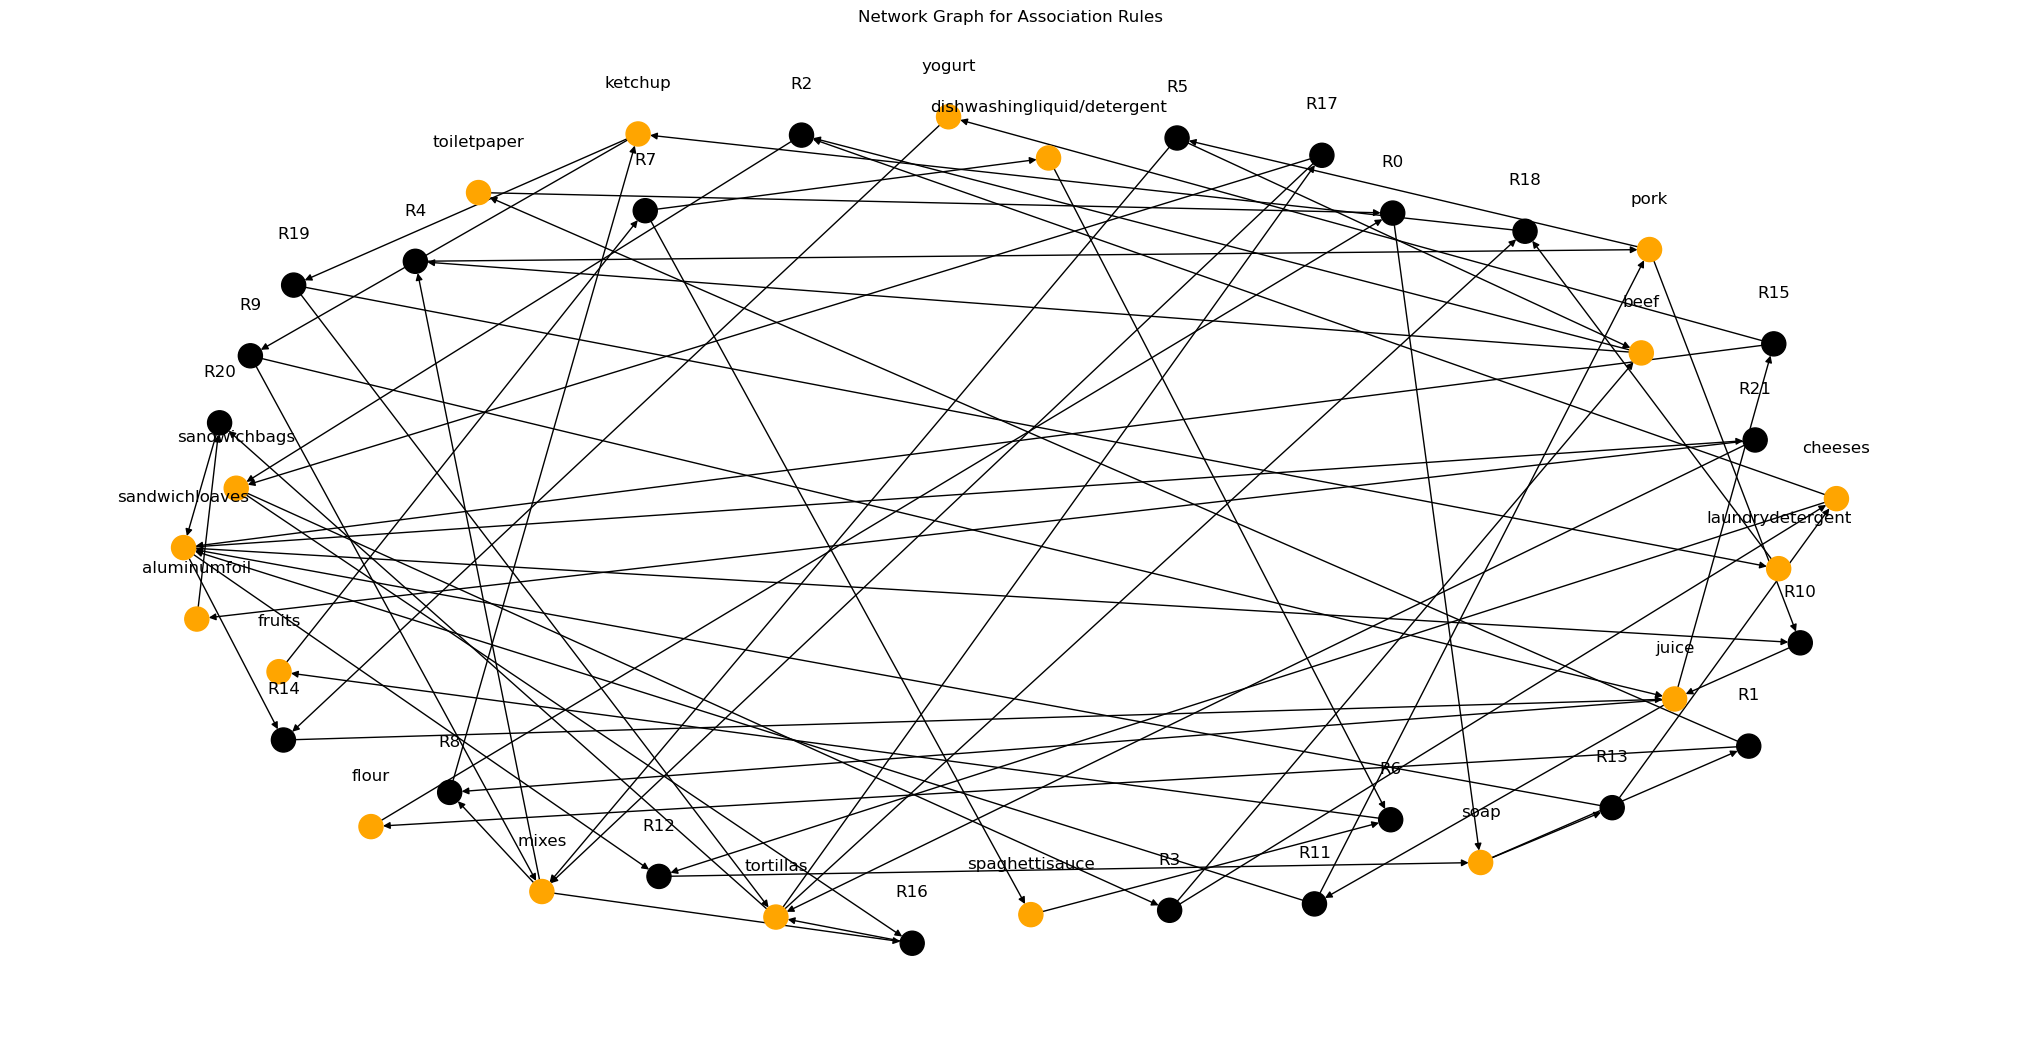

In [90]:
draw_network(rules_fpgrowth, 22);

#### Алгоритм FP-Max

In [113]:
frequent_itemsets_fpmax=fpmax(transactions, min_support= 1/len(goods), use_colnames=True, max_len = 3)

In [114]:
frequent_itemsets_fpmax['length']=frequent_itemsets_fpmax['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpmax

,support,itemsets,length


In [112]:
rules_fpmax = association_rules(frequent_itemsets_fpmax, metric="support", support_only=True)
display(rules_fpmax.sort_values (by='lift', ascending=False).head(5))
print("Rules identified: {}".format(len(rules_fpmax)))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Rules identified: 0


__Вывод:__
1. Наиболее частое сочетание (juice)-(sandwichloaves, yogurt). Lift 1.577639
2. Наиболее часто встречающимся товаром в сете является (vegetables). Support 0.597065
3. Минимальное количество сочетаний, при котором работают алгоритмы, 3 товара.